In [6]:
import torch
import torch.nn as nn
from torch.nn import Linear, Sequential, ReLU, GELU
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv, DeepGCNLayer, SSGConv, GPSConv
from layers.complex_valued_layers import UnitaryGCNConvLayer, GroupSort
from layers.real_valued_layers import OrthogonalGCNConvLayer
import torch_geometric.transforms as Transforms
import time
import argparse
from torch.optim.lr_scheduler import ReduceLROnPlateau

transform = Transforms.AddLaplacianEigenvectorPE(k=10, attr_name='pe') # Add Laplacian eigenvector positional encoding if desired to use it

class RingGraphDataset(torch.utils.data.Dataset):
    def __init__(self, n_data=100, n_nodes=20):
        self.n_data = n_data
        self.n_nodes = n_nodes

    def __len__(self):
        return self.n_data

    def __getitem__(self, idx):
        # Generate a ring graph
        edge_index = torch.cat([
            torch.tensor([[i, (i + 1) % self.n_nodes] for i in range(self.n_nodes)]),
            torch.tensor([[(i + 1) % self.n_nodes, i] for i in range(self.n_nodes)])], dim=0).t().contiguous()

        # Add trivial edge features (all set to 0)
        edge_attr = torch.zeros(edge_index.size(1), 1)

        x = torch.zeros(self.n_nodes, 1)

        # Randomly select two nodes and set their features to 1
        src = torch.randint(0, self.n_nodes, (1,))
        tgt = (src + torch.randint(1, self.n_nodes, (1,))) % self.n_nodes
        x[src] = 1
        x[tgt] = 1

        # Calculate the shortest path distance between the two selected nodes
        dist = min(abs(src - tgt), self.n_nodes - abs(src - tgt))

        dataset = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        dataset = transform(dataset)
        return dataset, torch.tensor(dist)
    

class UnitaryGCN(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        hidden_layer_dim: int,
        T: int = 15
    ):
        super(UnitaryGCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        taylor_layer = UnitaryGCNConvLayer(input_dim, hidden_dim, T=T, global_bias = False, bias = False, use_hermitian=False)
        self.conv_layers.append(taylor_layer)
        for _ in range(num_layers-1):
            taylor_layer = UnitaryGCNConvLayer(hidden_dim, hidden_dim, T=T, global_bias = False, bias = False, use_hermitian=False, activation = GroupSort)
            self.conv_layers.append(taylor_layer)
        self.hidden_layer = nn.Linear(hidden_dim, hidden_layer_dim)
        self.output_layer = nn.Linear(hidden_layer_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.conv_layers:
            data = conv(data)
        x = global_mean_pool(data.x.real, data.batch)  # Global pooling over nodes
        x = F.gelu(self.hidden_layer(x))  # Hidden layer with GELU activation
        x = self.output_layer(x)  # Output layer
        return x.squeeze()
    

class FlexibleGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim):
        super(FlexibleGCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.conv_layers.append(GCNConv(input_dim, hidden_dim))
            input_dim = hidden_dim
        self.hidden_layer = nn.Linear(hidden_dim, hidden_layer_dim)
        self.output_layer = nn.Linear(hidden_layer_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.conv_layers:
            x = conv(x, edge_index)
            x = F.gelu(x)
            x = F.dropout(x, training=self.training)
        x = global_mean_pool(x, data.batch)  # Global pooling over nodes
        x = F.gelu(self.hidden_layer(x))  # Hidden layer with GELU activation
        x = self.output_layer(x)  # Output layer
        return x.squeeze()
    

class ResidualGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim):
        super(ResidualGCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        for _ in range(num_layers):
            conv_layer = DeepGCNLayer(
                conv=GCNConv(input_dim, hidden_dim),
                act=F.gelu,
                block='res+',
                dropout=0.5
            )
            self.conv_layers.append(conv_layer)
            input_dim = hidden_dim
        self.hidden_layer = nn.Linear(hidden_dim, hidden_layer_dim)
        self.output_layer = nn.Linear(hidden_layer_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.conv_layers:
            x = conv(x, edge_index)
        x = global_mean_pool(x, data.batch)  # Global pooling over nodes
        x = F.gelu(self.hidden_layer(x))  # Hidden layer with GELU activation
        x = self.output_layer(x)  # Output layer
        return x.squeeze()

class SSGGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim, alpha=0.1, K=1):
        super(SSGGCN, self).__init__()
        self.num_layers = num_layers
        self.conv_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.conv_layers.append(SSGConv(input_dim, hidden_dim, alpha=alpha, K=K))
            input_dim = hidden_dim
        self.hidden_layer = nn.Linear(hidden_dim, hidden_layer_dim)
        self.output_layer = nn.Linear(hidden_layer_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.conv_layers:
            x = conv(x, edge_index)
            x = F.gelu(x)
            x = F.dropout(x, training=self.training)
        x = global_mean_pool(x, data.batch)  # Global pooling over nodes
        x = F.gelu(self.hidden_layer(x))  # Hidden layer with GELU activation
        x = self.output_layer(x)  # Output layer
        return x.squeeze()


In [7]:
# Parameters
n_data = 1000
n_nodes = 100
input_dim = 1
hidden_dim = 128
output_dim = 1
lr = 0.0001 # Learning rate set to 0.0001 (larger learning rates can cause divergence)
epochs = 50
num_layers = 20  # Number of convolutional layers
hidden_layer_dim = 128  # Dimension of the hidden layer
batch_size = 32
device = 'cuda:0'

# Create dataset and dataloader
dataset = RingGraphDataset(n_data, n_nodes)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Create test dataset and dataloader
test_dataset = RingGraphDataset(500, n_nodes)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Create validation dataset and dataloader
val_dataset = RingGraphDataset(200, n_nodes)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False)

# Initialize models, optimizers, and loss
models = {
    'Unitary GCN': UnitaryGCN(input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim),
    'Vanilla GCN': FlexibleGCN(input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim),
    'Spectral Convolution': SSGGCN(input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim, alpha = 0.1, K = 5),
    'Residual GCN': ResidualGCN(input_dim, hidden_dim, output_dim, num_layers, hidden_layer_dim),
}
# Dictionary to store train and test losses for each model
losses = {model_name: {'train': [], 'test': []} for model_name in models}

In [8]:

for model_name, model in models.items():
    print(f'Training {model_name}')
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100, min_lr=0.000001)

    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            optimizer.zero_grad()
            target = target.to(device)
            output = model(data.to(device))
            loss = criterion(output.squeeze(), target.squeeze().float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses[model_name]['train'].append(total_loss / len(loader))

        # Calculate test error
        model.eval()
        test_loss = 0
        val_loss = 0
        with torch.no_grad():
            for data, target in test_loader:
                target = target.to(device)
                output = model(data.to(device))
                test_loss += criterion(output.squeeze(), target.squeeze().float()).item()
            for data, target in val_loader:
                target = target.to(device)
                output = model(data.to(device))
                val_loss += criterion(output.squeeze(), target.squeeze().float()).item()
        losses[model_name]['test'].append(test_loss / len(test_loader))

        scheduler.step(val_loss)

        model.train()
        print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(loader)}, Test Loss: {test_loss / len(test_loader)}")

Training Unitary GCN


/tmp/ipykernel_217719/877744092.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return dataset, torch.tensor(dist)


Epoch 1, Train Loss: 24.720307767391205, Test Loss: 23.96048617362976
Epoch 2, Train Loss: 14.483227729797363, Test Loss: 11.506075501441956
Epoch 3, Train Loss: 11.69226399064064, Test Loss: 11.101284205913544
Epoch 4, Train Loss: 11.023284688591957, Test Loss: 11.611498355865479
Epoch 5, Train Loss: 10.978219836950302, Test Loss: 11.335440993309021
Epoch 6, Train Loss: 11.159074991941452, Test Loss: 10.8247612118721
Epoch 7, Train Loss: 10.779015183448792, Test Loss: 11.031825244426727
Epoch 8, Train Loss: 10.131078153848648, Test Loss: 10.71719640493393
Epoch 9, Train Loss: 10.165375530719757, Test Loss: 10.326792478561401
Epoch 10, Train Loss: 10.22067666053772, Test Loss: 10.38696151971817
Epoch 11, Train Loss: 9.91636161506176, Test Loss: 9.715669214725494
Epoch 12, Train Loss: 9.923804074525833, Test Loss: 9.941992342472076
Epoch 13, Train Loss: 9.742624819278717, Test Loss: 9.419141381978989
Epoch 14, Train Loss: 9.873145937919617, Test Loss: 10.466639757156372
Epoch 15, Train 

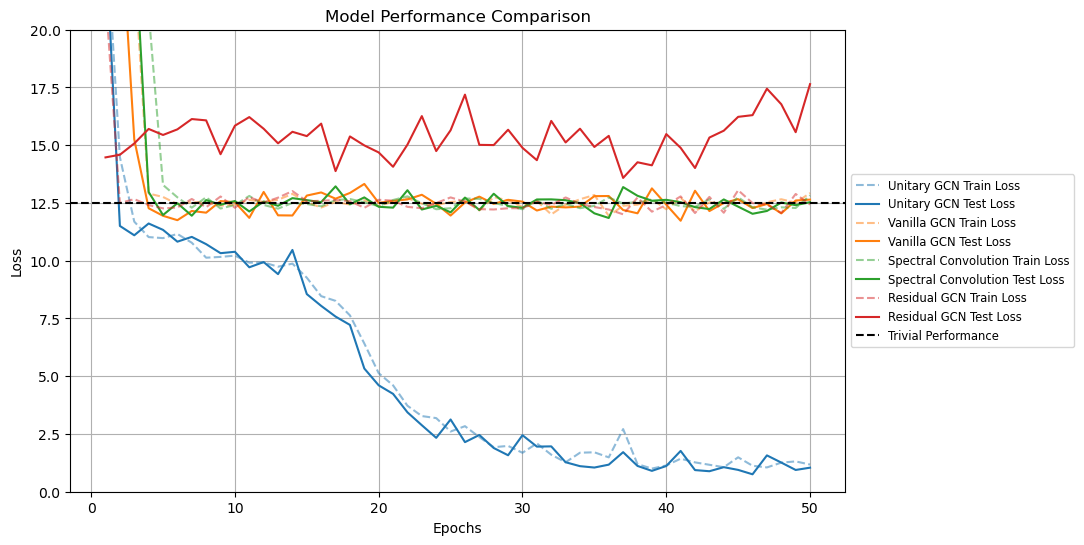

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame()

# Iterate through each model's dictionary
for model_name, errors in losses.items():
    train_errors = errors['train']
    test_errors = errors['test']
    
    # Create a DataFrame for the current model's errors
    model_df = pd.DataFrame({
        'Model': [model_name] * len(train_errors),
        'Epoch': range(len(train_errors)),
        'Train Error': train_errors,
        'Test Error': test_errors
    })
    
    # Concatenate the current model's DataFrame with the main DataFrame
    df = pd.concat([df, model_df], ignore_index=True)

# Set the 'Epoch' column as the index
df.set_index('Epoch', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10.colors  # Get a list of colors from the 'tab10' colormap

for i, (model_name, loss_dict) in enumerate(losses.items()):
    color = colors[i % len(colors)]  # Get color based on index to ensure same color for train and test
    plt.plot(range(1, epochs + 1), loss_dict['train'], '--', label=f'{model_name} Train Loss', alpha=0.5, color=color)
    plt.plot(range(1, epochs + 1), loss_dict['test'], label=f'{model_name} Test Loss', color=color)

plt.axhline(y=12.5, linestyle='--', color='black', label='Trivial Performance')
plt.ylim(0, 20)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Performance Comparison')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.show()
